# Colab Block
This block is only for setting up google drive access in Colabs to import and export data. Not needed if not using Colabs.

In [1]:
from google.colab import auth
auth.authenticate_user()
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}
!mkdir -p gdrive
!google-drive-ocamlfuse gdrive
!pip install -q keras
!pip install numba
!pip install tqdm
!pip install opencv-python
!apt update && apt install -y libsm6 libxext6

Preconfiguring packages ...
Selecting previously unselected package cron.
(Reading database ... 16712 files and directories currently installed.)
Preparing to unpack .../00-cron_3.0pl1-128ubuntu5_amd64.deb ...
Unpacking cron (3.0pl1-128ubuntu5) ...
Selecting previously unselected package libapparmor1:amd64.
Preparing to unpack .../01-libapparmor1_2.11.0-2ubuntu17.1_amd64.deb ...
Unpacking libapparmor1:amd64 (2.11.0-2ubuntu17.1) ...
Selecting previously unselected package libdbus-1-3:amd64.
Preparing to unpack .../02-libdbus-1-3_1.10.22-1ubuntu1_amd64.deb ...
Unpacking libdbus-1-3:amd64 (1.10.22-1ubuntu1) ...
Selecting previously unselected package dbus.
Preparing to unpack .../03-dbus_1.10.22-1ubuntu1_amd64.deb ...
Unpacking dbus (1.10.22-1ubuntu1) ...
Selecting previously unselected package dirmngr.
Preparing to unpack .../04-dirmngr_2.1.15-1ubuntu8_amd64.deb ...
Unpacking dirmngr (2.1.15-1ubuntu8) ...
Selecting previously unselected package distro-info-data.
Preparing to unpack .../0

Setting up unattended-upgrades (0.98ubuntu1.1) ...

Creating config file /etc/apt/apt.conf.d/20auto-upgrades with new version

Creating config file /etc/apt/apt.conf.d/50unattended-upgrades with new version
invoke-rc.d: could not determine current runlevel
invoke-rc.d: policy-rc.d denied execution of start.
Setting up dirmngr (2.1.15-1ubuntu8) ...
Setting up cron (3.0pl1-128ubuntu5) ...
Adding group `crontab' (GID 102) ...
Done.
update-rc.d: warning: start and stop actions are no longer supported; falling back to defaults
update-rc.d: warning: stop runlevel arguments (1) do not match cron Default-Stop values (none)
invoke-rc.d: could not determine current runlevel
invoke-rc.d: policy-rc.d denied execution of start.
Setting up libdbus-1-3:amd64 (1.10.22-1ubuntu1) ...
Setting up kmod (24-1ubuntu2) ...
Setting up libdbus-glib-1-2:amd64 (0.108-2) ...
Setting up python3-gi (3.24.1-2build1) ...
Setting up module-init-tools (24-1ubuntu2) ...
Setting up python3-software-properties (0.96.24.17)

    100% |████████████████████████████████| 14.8MB 92kB/s 
    100% |████████████████████████████████| 51kB 1.7MB/s 
Hit:1 http://archive.ubuntu.com/ubuntu artful InRelease
Hit:2 http://security.ubuntu.com/ubuntu artful-security InRelease
Hit:3 http://ppa.launchpad.net/alessandro-strada/ppa/ubuntu artful InRelease
Hit:4 http://archive.ubuntu.com/ubuntu artful-updates InRelease
Hit:5 http://archive.ubuntu.com/ubuntu artful-backports InRelease
Reading package lists... Done
Building dependency tree       
Reading state information... Done
20 packages can be upgraded. Run 'apt list --upgradable' to see them.
Reading package lists... Done
Building dependency tree       
Reading state information... Done
libsm6 is already the newest version (2:1.2.2-1).
libxext6 is already the newest version (2:1.3.3-1).
0 upgraded, 0 newly installed, 0 to remove and 20 not upgraded.


# Import and Load in the Data

Note: Due to security settings, Colab cannot preprocesses folders of images efficently so I worked on the image preprocessing elsewhere and packaged them into .npy files for easy load here. See the related notebook for preprocessing steps.

In [2]:

import keras
import keras.backend as K
from keras.models import Sequential, Model, load_model
from keras.layers import Dense, Dropout, Conv2D, MaxPooling2D, Flatten, MaxPool2D, BatchNormalization, Input, Lambda, Conv2DTranspose
from keras.layers.merge import concatenate
from keras.optimizers import RMSprop
from keras.models import Model
import pandas as pd
import numpy as np
import random
import math
import matplotlib.pyplot as plt
from keras import backend as K
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from numba import vectorize
from tqdm import tqdm
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from keras.layers.convolutional import Convolution2D, MaxPooling2D, ZeroPadding2D
from keras.layers.advanced_activations import LeakyReLU, PReLU
from keras.optimizers import Adam, SGD
import cv2
import sys
import warnings
import os

from tqdm import tqdm
from itertools import chain
from skimage.io import imread, imshow, imread_collection, concatenate_images
from skimage.transform import resize
from skimage.morphology import label

import tensorflow as tf

# GPU acceleration

os.environ["THEANO_FLAGS"] = "mode=FAST_RUN,device=gpu,floatX=float32"
# import theano
# don't overload gpu

config = K.tf.ConfigProto()
config.gpu_options.allow_growth = True
session = K.tf.Session(config=config)

Using TensorFlow backend.


In [0]:
# Set some parameters
BATCH_SIZE = 16
IMG_WIDTH = 256
IMG_HEIGHT = 256
IMG_CHANNELS = 3

warnings.filterwarnings('ignore', category=UserWarning, module='skimage')
SEED = 42

In [0]:

X_train = np.load('gdrive/Data_Science_Bowl_2018/DSB_X_Train_256_Clean_Crop.npy')
Y_train = np.load('gdrive/Data_Science_Bowl_2018/DSB_Y_Train_256_Clean_Crop.npy')
X_test = np.load('gdrive/Data_Science_Bowl_2018/DSB_X_Testv2_256.npy')

In [6]:
X_train.shape

(664, 256, 256, 3)

# Data Augmentation

In [0]:

image_datagen = ImageDataGenerator(
#         featurewise_center=False,  # set input mean to 0 over the dataset
#         samplewise_center=False,  # set each sample mean to 0
#         featurewise_std_normalization=False,  # divide inputs by std of the dataset
#         samplewise_std_normalization=False,  # divide each input by its std
#         zca_whitening=False,  # apply ZCA whitening
        rotation_range=50,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.25, # Randomly zoom image 
        shear_range=0.5,
#         channel_shift_range=0.2,
        width_shift_range=0.25,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.25,  # randomly shift images vertically (fraction of total height)
        fill_mode='reflect',
#         horizontal_flip=True,
#         vertical_flip=True,
        )


mask_datagen = ImageDataGenerator(
#         featurewise_center=False,  # set input mean to 0 over the dataset
#         samplewise_center=False,  # set each sample mean to 0
#         featurewise_std_normalization=False,  # divide inputs by std of the dataset
#         samplewise_std_normalization=False,  # divide each input by its std
#         zca_whitening=False,  # apply ZCA whitening
        rotation_range=50,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.25, # Randomly zoom image 
        shear_range=0.5,
#         channel_shift_range=0.2,
        width_shift_range=0.25,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.25,  # randomly shift images vertically (fraction of total height)
        fill_mode='reflect',
#         horizontal_flip=True,
#         vertical_flip=True,
        )


In [9]:
X_train, X_valid, Y_train, Y_valid = train_test_split(X_train, Y_train, shuffle=True, test_size=0.1, random_state=SEED)
X_train.shape

(597, 256, 256, 3)

In [0]:
image_datagen.fit(X_train, augment=True, seed=SEED)
mask_datagen.fit(Y_train, augment=True, seed=SEED)

x=image_datagen.flow(X_train,batch_size=BATCH_SIZE, shuffle=True, seed=SEED)
y=mask_datagen.flow(Y_train,batch_size=BATCH_SIZE, shuffle=True, seed=SEED)

In [0]:
# Creating the validation Image and Mask generator
image_datagen_val = ImageDataGenerator()
mask_datagen_val = ImageDataGenerator()

image_datagen_val.fit(X_valid, augment=True, seed=SEED)
mask_datagen_val.fit(Y_valid, augment=True, seed=SEED)

x_val=image_datagen_val.flow(X_valid,batch_size=BATCH_SIZE,shuffle=True,seed=SEED)
y_val=mask_datagen_val.flow(Y_valid,batch_size=BATCH_SIZE,shuffle=True,seed=SEED)

In [0]:
# #creating a training and validation generator that generate masks and images
train_generator = zip(x, y)
val_generator = zip(x_val, y_val)

# IoU metric

In [0]:
def iou_metric(y_true_in, y_pred_in, print_table=False):
    labels = label(y_true_in > 0.5)
    y_pred = label(y_pred_in > 0.5)
    
    true_objects = len(np.unique(labels))
    pred_objects = len(np.unique(y_pred))

    intersection = np.histogram2d(labels.flatten(), y_pred.flatten(), bins=(true_objects, pred_objects))[0]

    # Compute areas (needed for finding the union between all objects)
    area_true = np.histogram(labels, bins = true_objects)[0]
    area_pred = np.histogram(y_pred, bins = pred_objects)[0]
    area_true = np.expand_dims(area_true, -1)
    area_pred = np.expand_dims(area_pred, 0)

    # Compute union
    union = area_true + area_pred - intersection

    # Exclude background from the analysis
    intersection = intersection[1:,1:]
    union = union[1:,1:]
    union[union == 0] = 1e-9

    # Compute the intersection over union
    iou = intersection / union

    # Precision helper function
    def precision_at(threshold, iou):
        matches = iou > threshold
        true_positives = np.sum(matches, axis=1) == 1   # Correct objects
        false_positives = np.sum(matches, axis=0) == 0  # Missed objects
        false_negatives = np.sum(matches, axis=1) == 0  # Extra objects
        tp, fp, fn = np.sum(true_positives), np.sum(false_positives), np.sum(false_negatives)
        return tp, fp, fn

    # Loop over IoU thresholds
    prec = []
    if print_table:
        print("Thresh\tTP\tFP\tFN\tPrec.")
    for t in np.arange(0.5, 1.0, 0.05):
        tp, fp, fn = precision_at(t, iou)
        if (tp + fp + fn) > 0:
            p = tp / (tp + fp + fn)
        else:
            p = 0
        if print_table:
            print("{:1.3f}\t{}\t{}\t{}\t{:1.3f}".format(t, tp, fp, fn, p))
        prec.append(p)
    
    if print_table:
        print("AP\t-\t-\t-\t{:1.3f}".format(np.mean(prec)))
    return np.mean(prec)

def iou_metric_batch(y_true_in, y_pred_in):
    batch_size = y_true_in.shape[0]
    metric = []
    for batch in range(batch_size):
        value = iou_metric(y_true_in[batch], y_pred_in[batch])
        metric.append(value)
    return np.array(np.mean(metric), dtype=np.float32)

def my_iou_metric(label, pred):
    metric_value = tf.py_func(iou_metric_batch, [label, pred], tf.float32)
    return metric_value

# Build the U-Net model

In [18]:

inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
s = Lambda(lambda x: x / 255) (inputs)

c1 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (s)
c1 = Dropout(0.1) (c1)
c1 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c1)
p1 = MaxPooling2D((2, 2)) (c1)

c2 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p1)
c2 = Dropout(0.1) (c2)
c2 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c2)
p2 = MaxPooling2D((2, 2)) (c2)

c3 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p2)
c3 = Dropout(0.2) (c3)
c3 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c3)
p3 = MaxPooling2D((2, 2)) (c3)

c4 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p3)
c4 = Dropout(0.2) (c4)
c4 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c4)
p4 = MaxPooling2D(pool_size=(2, 2)) (c4)

c5 = Conv2D(512, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p4)
c5 = Dropout(0.3) (c5)
c5 = Conv2D(512, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c5)

u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same') (c5)
u6 = concatenate([u6, c4])
c6 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u6)
c6 = Dropout(0.2) (c6)
c6 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c6)

u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c6)
u7 = concatenate([u7, c3])
c7 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u7)
c7 = Dropout(0.2) (c7)
c7 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c7)

u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c7)
u8 = concatenate([u8, c2])
c8 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u8)
c8 = Dropout(0.1) (c8)
c8 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c8)

u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c8)
u9 = concatenate([u9, c1], axis=3)
c9 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u9)
c9 = Dropout(0.1) (c9)
c9 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c9)

outputs = Conv2D(1, (1, 1), activation='sigmoid') (c9)

model = Model(inputs=[inputs], outputs=[outputs])
model.compile(optimizer=Adam(lr=0.001),
              loss='binary_crossentropy',
              metrics=[ my_iou_metric],
             )
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
lambda_3 (Lambda)               (None, 256, 256, 3)  0           input_3[0][0]                    
__________________________________________________________________________________________________
conv2d_30 (Conv2D)              (None, 256, 256, 32) 896         lambda_3[0][0]                   
__________________________________________________________________________________________________
dropout_15 (Dropout)            (None, 256, 256, 32) 0           conv2d_30[0][0]                  
__________________________________________________________________________________________________
conv2d_31 

# Callbacks
Note: all are not used in every attempt but kept here for options

In [0]:
# Set a learning rate annealer
learning_rate_reduction = ReduceLROnPlateau(monitor='val_mean_iou',
                                            mode='max',
                                            patience=4, 
                                            verbose=1, 
                                            factor=0.4,
                                            min_lr=0.00001)
earlystopper = EarlyStopping(monitor='val_my_iou_metric',
                             patience=5,
                             verbose=1,
                             mode='max')
filepath = "gdrive/Data_Science_Bowl_2018/tmp_best_weights.h5"
checkpoint = ModelCheckpoint(filepath,
                             monitor='val_my_iou_metric',
                             mode='max',
                             save_best_only=True,
                             verbose=1,
                            )

class LearningRateTracker(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        print("LR:" + K.eval(self.model.optimizer.lr))


In [0]:
# model.load_weights('gdrive/Data_Science_Bowl_2018/Best_weights.h5')
# model.load_weights(filepath)

# Fit the Model

In [30]:
%%time

train_generator = zip(x, y)


history = model.fit_generator(train_generator,
                              epochs = 40,
                              validation_data=val_generator,
                              validation_steps=10,
                              steps_per_epoch=(X_train.shape[0] / BATCH_SIZE),
                              verbose = 2,
                              callbacks=[earlystopper, checkpoint])

Epoch 1/1000
 - 41s - loss: 0.0713 - mean_iou: 0.4409 - my_iou_metric: 0.4633 - val_loss: 0.0849 - val_mean_iou: 0.4413 - val_my_iou_metric: 0.5000

Epoch 00001: val_mean_iou improved from 0.44045 to 0.44129, saving model to gdrive/Data_Science_Bowl_2018/tmp_best_weights.h5
Epoch 2/1000
 - 41s - loss: 0.0695 - mean_iou: 0.4417 - my_iou_metric: 0.4741 - val_loss: 0.0866 - val_mean_iou: 0.4421 - val_my_iou_metric: 0.4909

Epoch 00002: val_mean_iou improved from 0.44129 to 0.44212, saving model to gdrive/Data_Science_Bowl_2018/tmp_best_weights.h5
Epoch 3/1000
 - 41s - loss: 0.0705 - mean_iou: 0.4424 - my_iou_metric: 0.4603 - val_loss: 0.0806 - val_mean_iou: 0.4429 - val_my_iou_metric: 0.4955

Epoch 00003: val_mean_iou improved from 0.44212 to 0.44290, saving model to gdrive/Data_Science_Bowl_2018/tmp_best_weights.h5
Epoch 4/1000
 - 40s - loss: 0.0654 - mean_iou: 0.4433 - my_iou_metric: 0.4724 - val_loss: 0.0783 - val_mean_iou: 0.4437 - val_my_iou_metric: 0.5028

Epoch 00004: val_mean_iou 

Epoch 16/1000
 - 40s - loss: 0.0688 - mean_iou: 0.4516 - my_iou_metric: 0.4566 - val_loss: 0.0813 - val_mean_iou: 0.4519 - val_my_iou_metric: 0.4905

Epoch 00016: val_mean_iou improved from 0.45129 to 0.45188, saving model to gdrive/Data_Science_Bowl_2018/tmp_best_weights.h5
Epoch 17/1000
 - 41s - loss: 0.0685 - mean_iou: 0.4521 - my_iou_metric: 0.4632 - val_loss: 0.0807 - val_mean_iou: 0.4525 - val_my_iou_metric: 0.4986

Epoch 00017: val_mean_iou improved from 0.45188 to 0.45247, saving model to gdrive/Data_Science_Bowl_2018/tmp_best_weights.h5
Epoch 18/1000
 - 41s - loss: 0.0694 - mean_iou: 0.4527 - my_iou_metric: 0.4799 - val_loss: 0.0810 - val_mean_iou: 0.4531 - val_my_iou_metric: 0.5003

Epoch 00018: val_mean_iou improved from 0.45247 to 0.45308, saving model to gdrive/Data_Science_Bowl_2018/tmp_best_weights.h5
Epoch 19/1000
 - 41s - loss: 0.0664 - mean_iou: 0.4533 - my_iou_metric: 0.4776 - val_loss: 0.0782 - val_mean_iou: 0.4537 - val_my_iou_metric: 0.5041

Epoch 00019: val_mean_

Epoch 31/1000
 - 41s - loss: 0.0704 - mean_iou: 0.4602 - my_iou_metric: 0.4635 - val_loss: 0.0738 - val_mean_iou: 0.4604 - val_my_iou_metric: 0.5211

Epoch 00031: val_mean_iou improved from 0.45996 to 0.46045, saving model to gdrive/Data_Science_Bowl_2018/tmp_best_weights.h5
Epoch 32/1000
 - 41s - loss: 0.0635 - mean_iou: 0.4607 - my_iou_metric: 0.4864 - val_loss: 0.0827 - val_mean_iou: 0.4610 - val_my_iou_metric: 0.4860

Epoch 00032: val_mean_iou improved from 0.46045 to 0.46097, saving model to gdrive/Data_Science_Bowl_2018/tmp_best_weights.h5
Epoch 33/1000
 - 40s - loss: 0.0632 - mean_iou: 0.4612 - my_iou_metric: 0.4843 - val_loss: 0.0752 - val_mean_iou: 0.4614 - val_my_iou_metric: 0.5125

Epoch 00033: val_mean_iou improved from 0.46097 to 0.46143, saving model to gdrive/Data_Science_Bowl_2018/tmp_best_weights.h5
Epoch 34/1000
 - 41s - loss: 0.0675 - mean_iou: 0.4617 - my_iou_metric: 0.4696 - val_loss: 0.0770 - val_mean_iou: 0.4620 - val_my_iou_metric: 0.5133

Epoch 00034: val_mean_

 - 41s - loss: 0.2634 - mean_iou: 0.4653 - my_iou_metric: 0.1469 - val_loss: 0.4270 - val_mean_iou: 0.4645 - val_my_iou_metric: 0.0990

Epoch 00046: val_mean_iou did not improve
Epoch 47/1000
 - 40s - loss: 2.0182 - mean_iou: 0.4629 - my_iou_metric: 0.0110 - val_loss: 2.4369 - val_mean_iou: 0.4606 - val_my_iou_metric: 0.0000e+00

Epoch 00047: val_mean_iou did not improve
Epoch 48/1000
 - 41s - loss: 2.4311 - mean_iou: 0.4583 - my_iou_metric: 0.0000e+00 - val_loss: 2.4369 - val_mean_iou: 0.4560 - val_my_iou_metric: 0.0000e+00

Epoch 00048: val_mean_iou did not improve
Epoch 49/1000
 - 40s - loss: 2.3413 - mean_iou: 0.4538 - my_iou_metric: 0.0000e+00 - val_loss: 2.4369 - val_mean_iou: 0.4517 - val_my_iou_metric: 0.0000e+00

Epoch 00049: val_mean_iou did not improve
Epoch 00049: early stopping
CPU times: user 46min 18s, sys: 4min 5s, total: 50min 24s
Wall time: 43min 54s


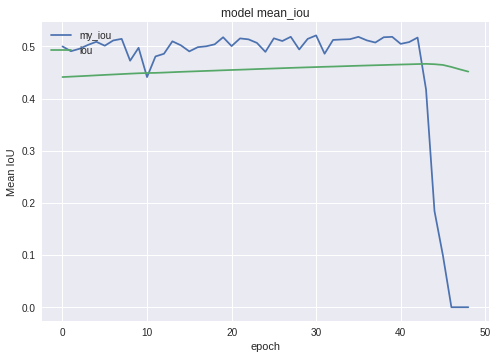

In [31]:
# summarize history for accuracy
plt.plot(history.history['val_my_iou_metric'])
plt.title('model mean_iou')
plt.ylabel('Mean IoU')
plt.xlabel('epoch')
plt.legend([ 'iou'], loc='upper left')
plt.show()

# Make Object Detection Predictions
Note: It is best to save the model and load it here after reloading the notebook or removing the training data from memory. The size of the training and test data sets loaded together will likely overload most memory limits, including Colab's 12GB limit. A good strategy is to load the training and testing seperatly to provide more memory for training.

In [0]:
model.load_weights(filepath)
# model.save_weights('gdrive/Data_Science_Bowl_2018/Best_weights.h5')
# model.save('gdrive/Data_Science_Bowl_2018/DSBowl2018_Model.h5')

In [0]:
# model = load_model('gdrive/Data_Science_Bowl_2018/DSBowl2018_Model.h5', custom_objects={'mean_iou': mean_iou,'my_iou_metric': my_iou_metric})
test_ids = np.load('gdrive/Data_Science_Bowl_2018/DSB_Testv2_ids_256.npy')
X_test = np.load('gdrive/Data_Science_Bowl_2018/DSB_X_Testv2_256.npy')
sizes_test = np.load('gdrive/Data_Science_Bowl_2018/DSB_Testv2_Sizes_256.npy')

In [0]:
# preds_train = model.predict(X_train, verbose=1)
# preds_val = model.predict(X_valid, verbose=1)

In [0]:
# preds_train_t = (preds_train > 0.5).astype(np.uint8)
# preds_val_t = (preds_val > 0.5).astype(np.uint8)

In [33]:
preds_test = model.predict(X_test, verbose=1)

3019/3019 [==============================] - 41s 14ms/step


In [0]:

preds_test_t = (preds_test > 0.5).astype(np.uint8)

# Create list of upsampled test masks
preds_test_upsampled = []
for i in range(len(preds_test)):
    preds_test_upsampled.append(resize(np.squeeze(preds_test[i]), 
                                       (sizes_test[i][0], sizes_test[i][1]), 
                                       mode='constant', preserve_range=True))

In [0]:
# Run-length encoding stolen from https://www.kaggle.com/rakhlin/fast-run-length-encoding-python
def rle_encoding(x):
    dots = np.where(x.T.flatten() == 1)[0]
    run_lengths = []
    prev = -2
    for b in dots:
        if (b>prev+1): run_lengths.extend((b + 1, 0))
        run_lengths[-1] += 1
        prev = b
    return run_lengths

def prob_to_rles(x, cutoff=0.5):
    lab_img = label(x > cutoff)
    for i in range(1, lab_img.max() + 1):
        yield rle_encoding(lab_img == i)

In [36]:
new_test_ids = []
rles = []
count = 0
for n, id_ in enumerate(test_ids):
    rle = list(prob_to_rles(preds_test_upsampled[n]))
#     lab_img = label(preds_test_upsampled[n] > 0.5)
#     for i in range(1, lab_img.max() + 1):
#       count += len(rle_encoding(lab_img == i))
    count += len(rle)
    rles.extend(rle)
    new_test_ids.extend([id_] * len(rle))
    
print(count)

149040


In [0]:
# Create submission DataFrame
sub = pd.DataFrame()
sub['ImageId'] = new_test_ids
sub['EncodedPixels'] = pd.Series(rles).apply(lambda x: ' '.join(str(y) for y in x))
sub.to_csv('gdrive/Data_Science_Bowl_2018/DSB2018_UNETv2.csv', index=False)

In [24]:
len(sub)

132977